/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Iteraciones: 301

Segundos entrenamiento: 179.481436
Minutos entrenamiento: 2.991357266666667

Segundos muestreo: 0.0006940000000099644
Minutos muestreo: 1.156666666683274e-05

Segundos total: 179.48213
Minutos total: 2.9913688333333335


Theta A: 0.7798028530951817
Theta B: 0.6760163585499588

Real:
Theta A: 0.7
Theta B: 0.66

Parámetros
Alfa: 21.396928649492093
Beta: 6.876022984878376
Gamma: 15.934258853077976
Eta: 6.784519656163218


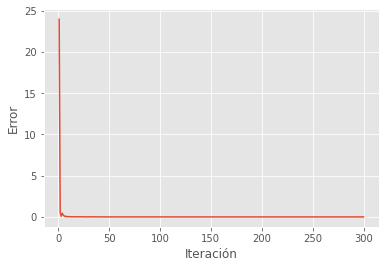

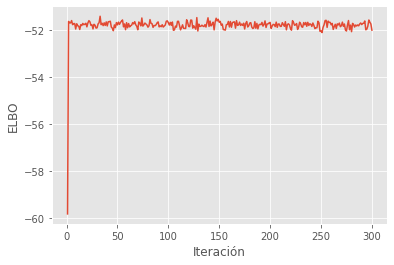

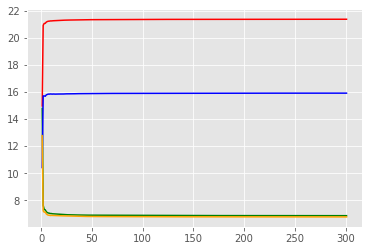

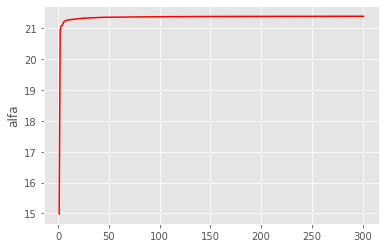

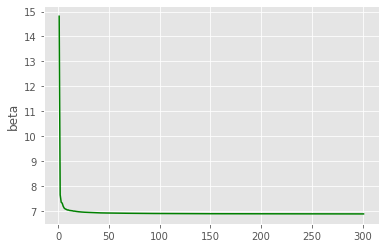

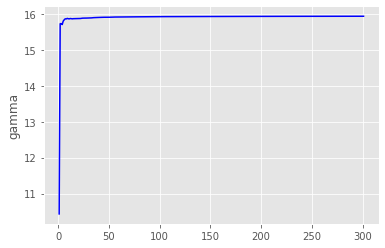

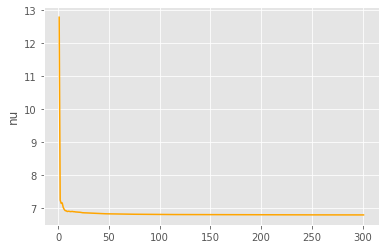

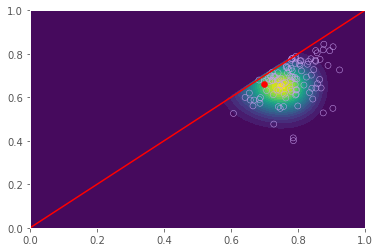

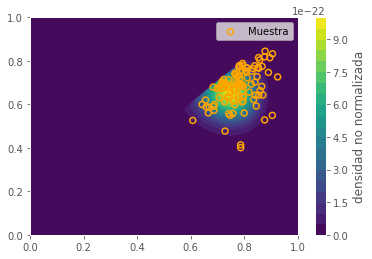

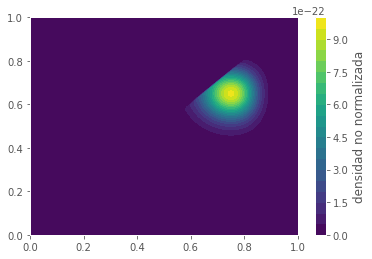

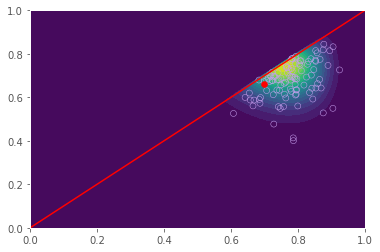

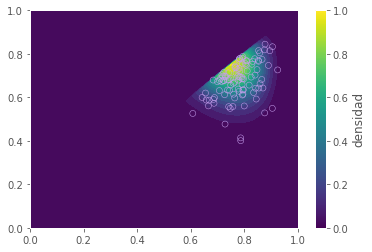

In [1]:
# Ejemplo betas, priori estadísticos de orden
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import mpmath as mp
import time
from scipy import special
from scipy import stats
plt.style.use('ggplot')
tim1=time.clock()

tam=100 # tamaño muestra Monte Carlo
tam_muestra=100 # tamaño muestra aproximante
n_a=40 # número de observaciones provenientes de theta A
n_b=40 # número de observaciones provenientes de theta B
np.random.seed(345)
theta=np.array([0.7,0.66])
x=np.random.binomial(1,theta[0],size=n_a) # observaciones provenientes de theta A
y=np.random.binomial(1,theta[1],size=n_b) # observaciones provenientes de theta B
s_a=np.sum(x)
s_b=np.sum(y)
params=np.random.uniform(size=4)*10+10 # se inicializan parámetros de distribución aproximante
t=1
dif=1.0
latente=np.zeros((2,tam)) # matriz para guardar simulaciones para Monte Carlo
lambdas=np.array([0.0]) # vector para guardar cambio en parámetros
g=np.zeros(4) # variable donde se acumula diagonal de producto externo
tiempo=np.array([t])
parametros=params.copy() # vector para guardar historia de parámetros
parametros=np.reshape(parametros,(4,1))
elbo=np.array([0.0])

while dif>10**-5: 
  latente_m=np.zeros((2,tam))
  latente_m[0,:]=np.random.beta(a=params[0],b=params[1],size=tam) # generación observaciones para Monte Carlo
  latente_m[1,:]=np.random.beta(a=params[2],b=params[3],size=tam) # generación observaciones para Monte Carlo
  latente_m=np.sort(latente_m,axis=0)
  latente[0,:]=latente_m[1,:]
  latente[1,:]=latente_m[0,:]
  ss=np.zeros(4) # variable para acumular gradientes
  beta1=sp.stats.beta(a=params[0],b=params[1])
  beta2=sp.stats.beta(a=params[2],b=params[3])
  for i in range(tam):
    p_cont=s_a*np.log(latente[0,i])*(n_a-s_a)+np.log(1-latente[0,i])+s_b*np.log(latente[1,i])+(n_b-s_a)*np.log(1-latente[1,i]) # logverosimilitud
    q=np.log(beta1.pdf(latente[0,i])*beta2.pdf(latente[1,i])+beta2.pdf(latente[0,i])*beta1.pdf(latente[1,i])) # logaritmo de densidad aproximante
    parcial_dens=np.zeros((4,2)) # variable para guardar derivadas parciales
    for j in range(2): # se obtienen derivadas parciales
      parcial_dens[0,j]=beta1.pdf(latente[j,i])*(np.log(latente[j,i])+sp.special.digamma(params[0]+params[1])-sp.special.digamma(params[0]))
      parcial_dens[1,j]=beta1.pdf(latente[j,i])*(np.log(1-latente[j,i])+sp.special.digamma(params[0]+params[1])-sp.special.digamma(params[1]))
      parcial_dens[2,j]=beta2.pdf(latente[j,i])*(np.log(latente[j,i])+sp.special.digamma(params[2]+params[3])-sp.special.digamma(params[2]))
      parcial_dens[3,j]=beta2.pdf(latente[j,i])*(np.log(1-latente[j,i])+sp.special.digamma(params[2]+params[3])-sp.special.digamma(params[3]))
    ss[0]+=((beta2.pdf(latente[1,i])*parcial_dens[0,0]+beta2.pdf(latente[0,i])*parcial_dens[0,1])/(beta1.pdf(latente[0,i])*beta2.pdf(latente[1,i])+beta2.pdf(latente[0,i])*beta1.pdf(latente[1,i])))*(p_cont-q)
    ss[1]+=((beta2.pdf(latente[1,i])*parcial_dens[1,0]+beta2.pdf(latente[0,i])*parcial_dens[1,1])/(beta1.pdf(latente[0,i])*beta2.pdf(latente[1,i])+beta2.pdf(latente[0,i])*beta1.pdf(latente[1,i])))*(p_cont-q)
    ss[2]+=((beta1.pdf(latente[0,i])*parcial_dens[2,1]+beta1.pdf(latente[1,i])*parcial_dens[2,0])/(beta1.pdf(latente[0,i])*beta2.pdf(latente[1,i])+beta2.pdf(latente[0,i])*beta1.pdf(latente[1,i])))*(p_cont-q)
    ss[3]+=((beta1.pdf(latente[0,i])*parcial_dens[3,1]+beta1.pdf(latente[1,i])*parcial_dens[3,0])/(beta1.pdf(latente[0,i])*beta2.pdf(latente[1,i])+beta2.pdf(latente[0,i])*beta1.pdf(latente[1,i])))*(p_cont-q)
  for j in range(4):
    g[j]+=(ss[j]/tam)**2 # se acumula cuadrado de gradiente
  ro=np.zeros(2)
  ro=1.0/(np.sqrt(g)*t*np.log(t)+1) # tasa AdaGrad
  log_theta_a=np.mean(np.log(latente[0,:])) # auxiliar para obtener ELBO
  log_theta_a_1=np.mean(np.log(1-latente[0,:])) # auxiliar para obtener ELBO
  log_theta_b=np.mean(np.log(latente[1,:])) # auxiliar para obtener ELBO
  log_theta_b_1=np.mean(np.log(1-latente[1,:])) # auxiliar para obtener ELBO
  log_theta_q=np.mean(np.log(beta1.pdf(latente[0,:])*beta2.pdf(latente[1,:])+beta2.pdf(latente[0,:])*beta1.pdf(latente[1,:]))) # auxiliar para obtener ELBO
  params+=np.array([ro*ss/tam]).astype(float)[0] # se actualiza nparámetros
  e1=np.array([ro*ss/tam]).astype(float)[0] # se guarda cambio de parámetros
  for i in range(4):
    if params[i]<=0:
      params[i]+=-np.array([ro[i]*ss[i]/tam]).astype(float)[0]
      e1[i]=0.0
  auxx=params.copy()
  auxx=np.reshape(auxx,(4,1))
  parametros=np.column_stack((parametros,auxx))
  t+=1
  dif=np.sum(abs(e1))
  lambdas=np.concatenate((lambdas,np.array([dif])))
  tiempo=np.concatenate((tiempo,np.array([t])))
  calc=np.log(2)+s_a*log_theta_a+(n_a-s_a)*log_theta_a_1+s_b*log_theta_b+(n_b-s_b)*log_theta_b_1-log_theta_q
  elbo=np.concatenate((elbo,np.array([calc])))

tim_entr=time.clock() #termina tiempo de entrenamiento

lambdas=lambdas[1:np.size(lambdas)]
elbo=elbo[1:np.size(elbo)]
tiempo1=tiempo[0:t-1]

mues_bet=np.zeros((2,tam_muestra))
mues_bet[0,:]=np.random.beta(a=params[0],b=params[1],size=tam_muestra)
mues_bet[1,:]=np.random.beta(a=params[2],b=params[3],size=tam_muestra)
mues_bet=np.sort(mues_bet,axis=0)
mues_a=mues_bet[1,:]
mues_b=mues_bet[0,:]

tim2=time.clock()
timf=tim2-tim1
tim_e=tim_entr-tim1
tim_e_mins=tim_e/60.0
timf_m=timf/60.0
tim_mues=tim2-tim_entr
tim_mues_mins=tim_mues/60.0

beta1=sp.stats.beta(a=params[0],b=params[1])
beta2=sp.stats.beta(a=params[2],b=params[3])

print("Iteraciones: ", t,sep="")
print("")
print("Segundos entrenamiento: ", tim_e,sep="")
print("Minutos entrenamiento: ", tim_e_mins,sep="")
print("")
print("Segundos muestreo: ", tim_mues,sep="")
print("Minutos muestreo: ", tim_mues_mins,sep="")
print("")
print("Segundos total: ", timf,sep="")
print("Minutos total: ", timf_m,sep="")
print("")
print("")
print("Theta A: ",np.mean(mues_a),sep="")
print("Theta B: ",np.mean(mues_b),sep="")
print("")
print("Real:")
print("Theta A: ",theta[0],sep="")
print("Theta B: ",theta[1],sep="")
print("")
print("Parámetros")
print("Alfa: ",params[0],sep="")
print("Beta: ",params[1],sep="")
print("Gamma: ",params[2],sep="")
print("Eta: ",params[3],sep="")

plt.plot(tiempo1,lambdas)
plt.ylabel("Error")
plt.xlabel("Iteración")
plt.show()

plt.plot(tiempo1,elbo)
plt.ylabel("ELBO")
plt.xlabel("Iteración")
plt.show()

plt.plot(tiempo,parametros[0,:],color="red")
plt.plot(tiempo,parametros[1,:],color="green")
plt.plot(tiempo,parametros[2,:],color="blue")
plt.plot(tiempo,parametros[3,:],color="orange")
plt.show()

plt.plot(tiempo,parametros[0,:],color="red")
plt.ylabel("alfa")
plt.show()
plt.plot(tiempo,parametros[1,:],color="green")
plt.ylabel("beta")
plt.show()
plt.plot(tiempo,parametros[2,:],color="blue")
plt.ylabel("gamma")
plt.show()
plt.plot(tiempo,parametros[3,:],color="orange")
plt.ylabel("nu")
plt.show()


def uniforme1(a,b):
  if b>0 and b <=a and a<1:
    ff=s_a*np.log(a)+(n_a-s_a)*np.log(1-a)+s_b*np.log(b)+(n_b-s_b)*np.log(1-b)
    ff=np.exp(ff)
  else:
    ff=0.0
  return ff

def uniforme2(a,b):
  if b>0 and a<1 and b <=a:
    ff=np.log(beta1.pdf(a)*beta2.pdf(b)+beta2.pdf(a)*beta1.pdf(b))
    ff=np.exp(ff)
  else:
    ff=0.0
  return ff

parta=125
partb=125
Z=np.zeros((parta,partb))

ainf=0.0
asup=1.0
binf=0.0
bsup=1.0

a=0
for i in np.linspace(ainf,asup,parta):
  b=0
  for j in np.linspace(binf,bsup,partb):
      Z[a,b]=uniforme1(i,j)
      b=b+1
  a=a+1

l1=np.linspace(0,1,num=10)
plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z),levels=20)
plt.scatter(mues_a,mues_b,facecolors="none",edgecolors="xkcd:lavender")
plt.scatter(theta[0],theta[1],facecolors="r")
plt.plot(l1,l1,color="r")
plt.show()

plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z),levels=20)
plt.colorbar().ax.set_ylabel('densidad no normalizada')
plt.scatter(mues_a,mues_b,marker='o',color="orange",facecolors='none',label='Muestra',linewidth=1.5)
plt.legend()
#plt.scatter(theta[0],theta[1],facecolors="r")
#plt.plot(l1,l1,color="r")
plt.show()

plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z),levels=20)
#plt.scatter(mues_a,mues_b,facecolors="none",edgecolors="xkcd:lavender")
plt.colorbar().ax.set_ylabel('densidad no normalizada')
#plt.scatter(theta[0],theta[1],facecolors="r")
#plt.plot(l1,l1,color="r")
plt.show()

parta=125
partb=125
Z=np.zeros((parta,partb))

ainf=0.0
asup=1.0
binf=0.0
bsup=1.0


a=0
for i in np.linspace(ainf,asup,parta):
  b=0
  for j in np.linspace(binf,bsup,partb):
      Z[a,b]=uniforme2(i,j)
      b=b+1
  a=a+1

plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z),levels=20)
plt.scatter(mues_a,mues_b,facecolors="none",edgecolors="xkcd:lavender")
plt.scatter(theta[0],theta[1],facecolors="r")
plt.plot(l1,l1,color="r")
plt.show()

plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z),levels=20)
plt.scatter(mues_a,mues_b,facecolors="none",edgecolors="xkcd:lavender")
plt.colorbar().ax.set_ylabel('densidad')
#plt.scatter(theta[0],theta[1],facecolors="r")
#plt.plot(l1,l1,color="r")
plt.show()
#t


